In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pywt
import random

SEED = 5000
random.seed(SEED)

In [2]:
train_sig = pd.read_parquet('../output/train_sig_2500hz_4th_order.parquet')

In [3]:
train_meta = pd.read_csv('../output/train_sampled.csv', index_col=0)

In [4]:
train_meta.head()

,signal_id,id_measurement,phase,target
3,3,1,0,1
4,4,1,1,1
5,5,1,2,1
201,201,67,0,1
202,202,67,1,1


In [5]:
train_sig.head()

,3,4,5,201,202,228,229,230,270,271,...,4299,2329,6863,4863,5327,5506,6438,7197,2367,7704
0,-0.096970,0.109313,-0.408393,-1.123261,-0.450745,-0.062333,-0.721372,0.015072,-0.497982,-0.663616,...,-0.031556,1.129117,-0.720609,-1.876291,0.303274,0.745392,-1.070064,1.685602,0.242510,-0.170972
1,-1.097059,-0.890614,-0.408473,-2.123089,-1.450280,-0.062838,-0.721856,-0.985411,1.502143,1.336429,...,-2.031030,1.128936,-1.720583,-1.875478,-0.696200,1.746031,-2.069847,1.685527,0.242650,-0.170764
2,-1.097149,-0.890541,-0.408552,-3.122917,-3.449815,-0.063343,-1.722341,-0.985895,-0.497732,-0.663526,...,-2.030504,1.128754,-1.720558,-5.874665,-3.695675,-2.253331,-2.069631,1.685452,-0.757209,-1.170555
3,-0.097238,0.109532,0.591368,-0.122744,0.550649,-1.063849,-1.722826,0.013622,-0.497607,-1.663481,...,-0.029978,1.128573,0.279468,-0.873851,0.304851,-6.252692,-2.069414,1.685376,-1.757068,-0.170346
4,-0.097327,0.109605,0.591288,-4.122572,-3.448886,-1.064354,-1.723310,0.013138,-0.497483,0.336564,...,-2.029452,0.128392,-0.720506,-3.873038,0.305376,-7.252053,-1.069198,2.685301,-0.756928,-2.170138


In [6]:
train_sig.shape

(800000, 1050)

In [7]:
random.choices(train_sig.columns.tolist(), k=10)

['4086',
 '1266',
 '7775',
 '4915',
 '6432',
 '4263',
 '5307',
 '6985',
 '5123',
 '1017']

In [8]:
def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [9]:
def denoise_signal( x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest( coeff[-level] )

    # Calculte the univeral threshold
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff, wavelet, mode='per' )

In [10]:
train_sig_denoised = denoise_signal(train_sig, wavelet='haar', level=1)

In [11]:
train_denoised_df = pd.DataFrame(train_sig_denoised, columns=train_sig.columns.tolist())

In [12]:
train_denoised_df.head()

,3,4,5,201,202,228,229,230,270,271,...,4299,2329,6863,4863,5327,5506,6438,7197,2367,7704
0,-0.011914,-0.011914,-0.011914,-0.011914,-0.011914,-0.011914,-0.011914,-0.011914,-0.011914,-0.011914,...,0.120092,0.120092,0.120092,0.120092,0.120092,0.120092,0.120092,0.120092,0.120092,0.120092
1,-0.010937,-0.010937,-0.010937,-0.010937,-0.010937,-0.010937,-0.010937,-0.010937,-0.010937,-0.010937,...,0.088894,0.088894,0.088894,0.088894,0.088894,0.088894,0.088894,0.088894,0.088894,0.088894
2,-0.161328,-0.161328,-0.161328,-0.161328,-0.161328,-0.161328,-0.161328,-0.161328,-0.161328,-0.161328,...,-0.223554,-0.223554,-0.223554,-0.223554,-0.223554,-0.223554,-0.223554,-0.223554,-0.223554,-0.223554
3,-0.091992,-0.091992,-0.091992,-0.091992,-0.091992,-0.091992,-0.091992,-0.091992,-0.091992,-0.091992,...,-0.192252,-0.192252,-0.192252,-0.192252,-0.192252,-0.192252,-0.192252,-0.192252,-0.192252,-0.192252
4,-0.001171,-0.001171,-0.001171,-0.001171,-0.001171,-0.001171,-0.001171,-0.001171,-0.001171,-0.001171,...,-0.285950,-0.285950,-0.285950,-0.285950,-0.285950,-0.285950,-0.285950,-0.285950,-0.285950,-0.285950


In [13]:
train_denoised_df.shape

(800000, 1050)

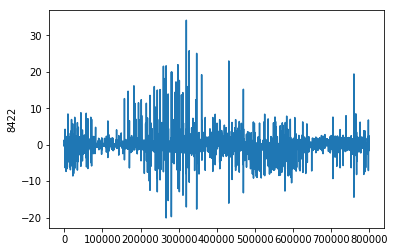

8422    1
Name: target, dtype: int64


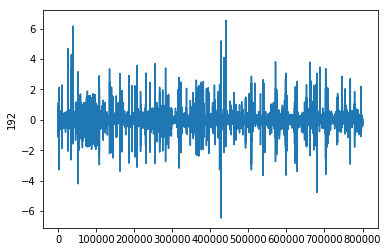

192    0
Name: target, dtype: int64


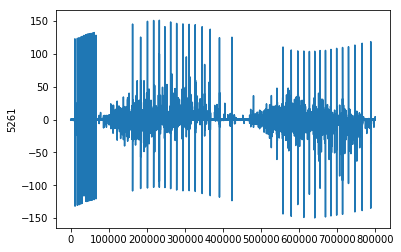

5261    0
Name: target, dtype: int64


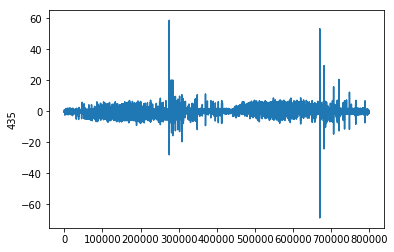

435    1
Name: target, dtype: int64


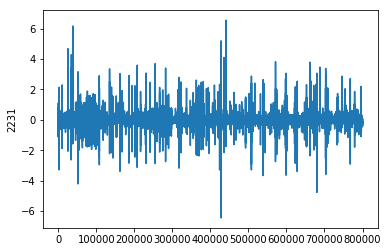

2231    0
Name: target, dtype: int64


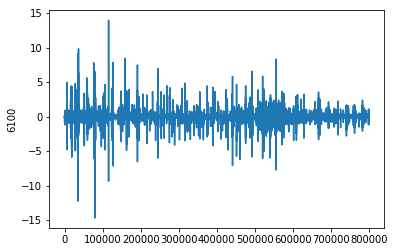

6100    0
Name: target, dtype: int64


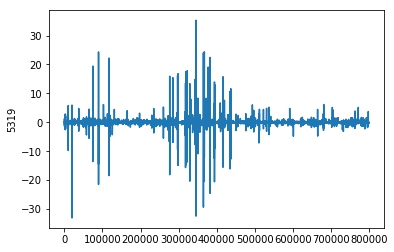

5319    0
Name: target, dtype: int64


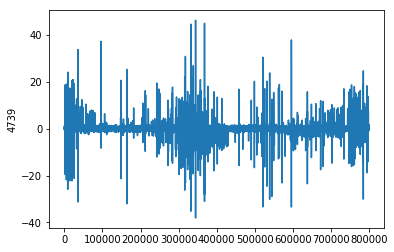

4739    1
Name: target, dtype: int64


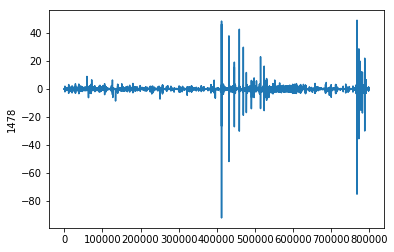

1478    0
Name: target, dtype: int64


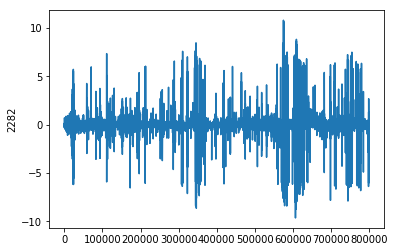

2282    0
Name: target, dtype: int64


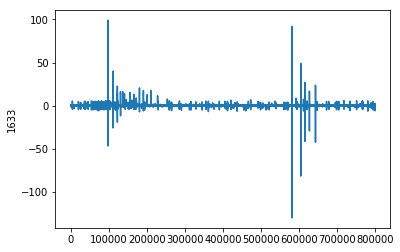

1633    0
Name: target, dtype: int64


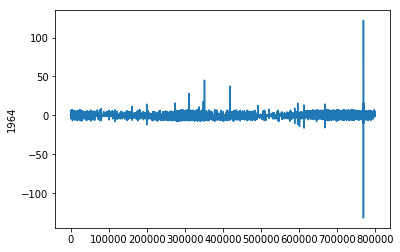

1964    0
Name: target, dtype: int64


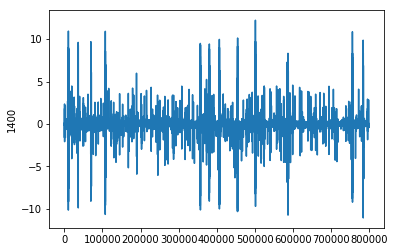

1400    0
Name: target, dtype: int64


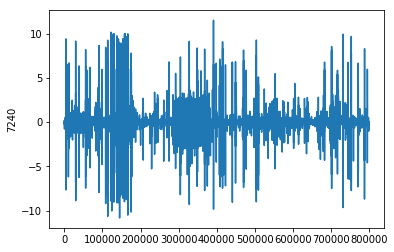

7240    0
Name: target, dtype: int64


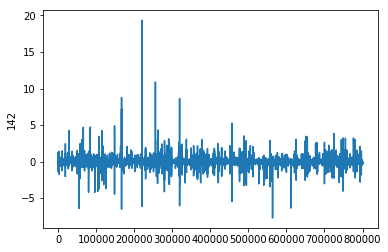

142    0
Name: target, dtype: int64


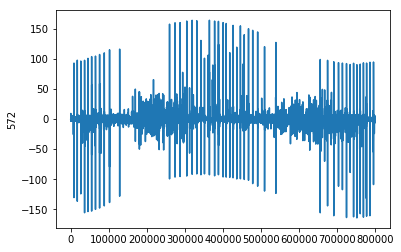

572    1
Name: target, dtype: int64


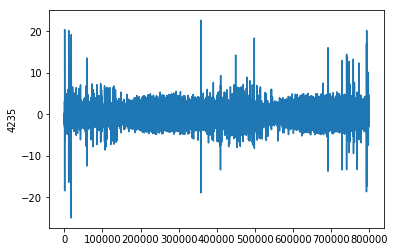

4235    1
Name: target, dtype: int64


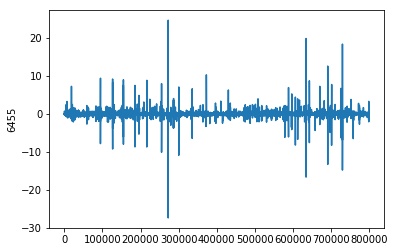

6455    0
Name: target, dtype: int64


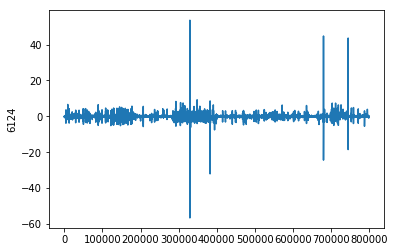

6124    0
Name: target, dtype: int64


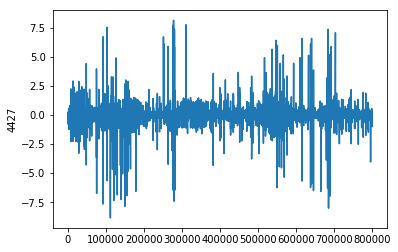

4427    0
Name: target, dtype: int64


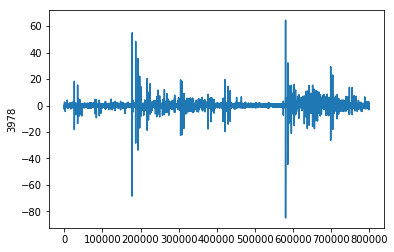

3978    1
Name: target, dtype: int64


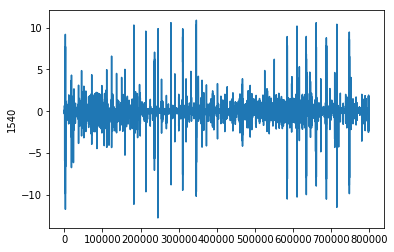

1540    0
Name: target, dtype: int64


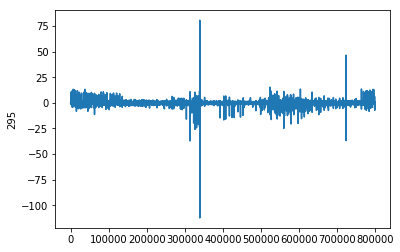

295    1
Name: target, dtype: int64


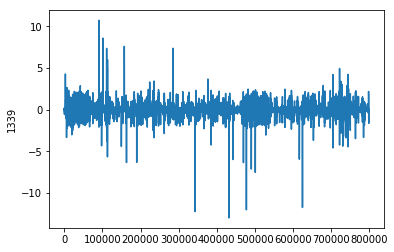

1339    0
Name: target, dtype: int64


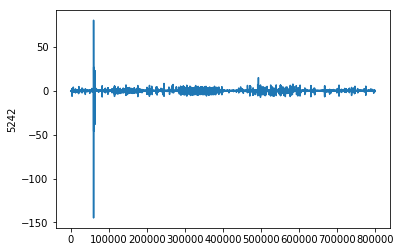

5242    0
Name: target, dtype: int64


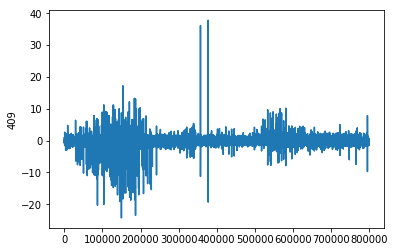

409    1
Name: target, dtype: int64


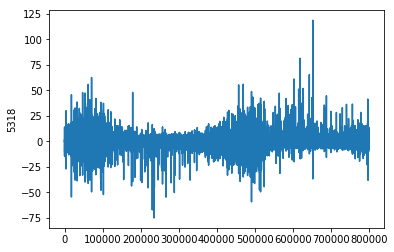

5318    1
Name: target, dtype: int64


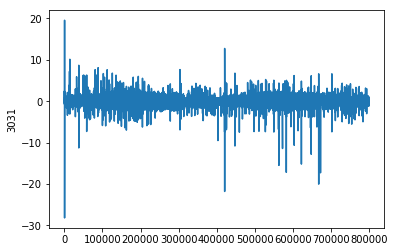

3031    1
Name: target, dtype: int64


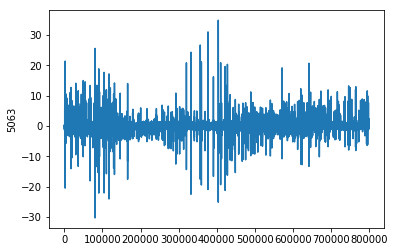

5063    1
Name: target, dtype: int64


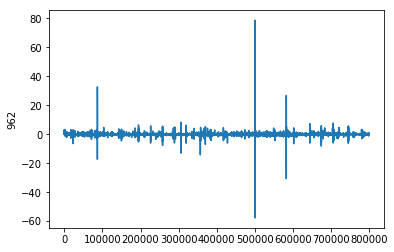

962    0
Name: target, dtype: int64


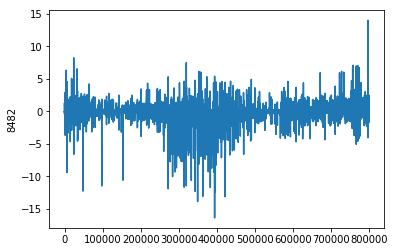

8482    1
Name: target, dtype: int64


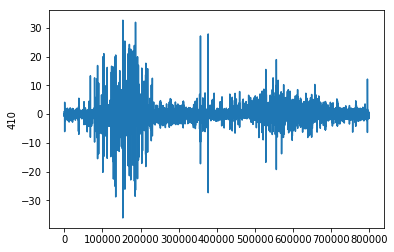

410    1
Name: target, dtype: int64


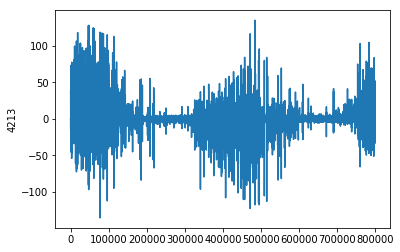

4213    1
Name: target, dtype: int64


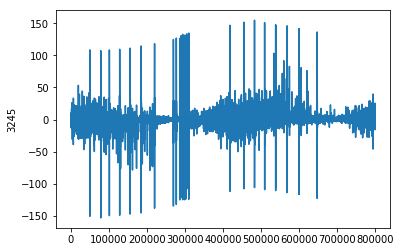

3245    1
Name: target, dtype: int64


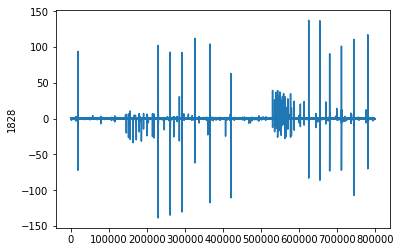

1828    0
Name: target, dtype: int64


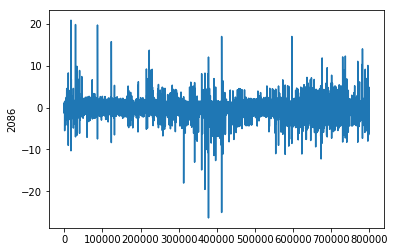

2086    1
Name: target, dtype: int64


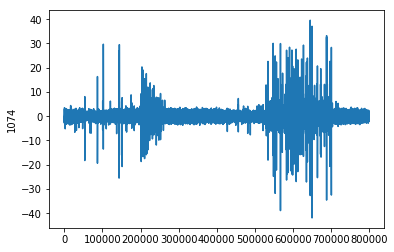

1074    1
Name: target, dtype: int64


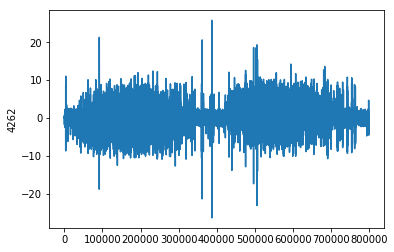

4262    1
Name: target, dtype: int64


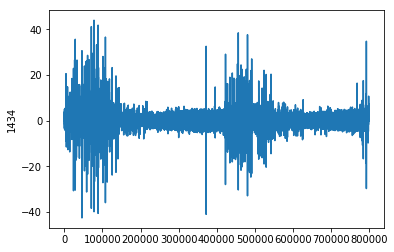

1434    1
Name: target, dtype: int64


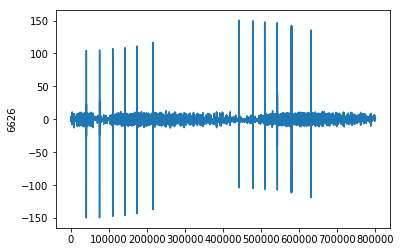

6626    0
Name: target, dtype: int64


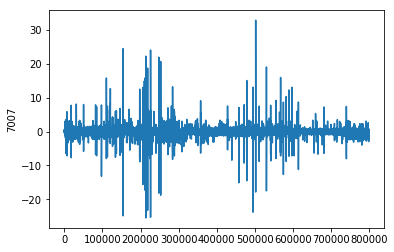

7007    1
Name: target, dtype: int64


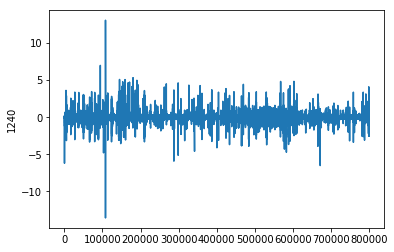

1240    0
Name: target, dtype: int64


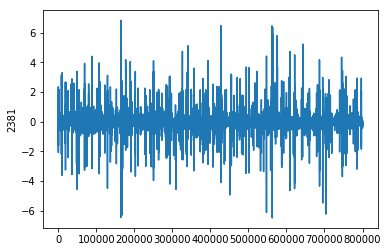

2381    0
Name: target, dtype: int64


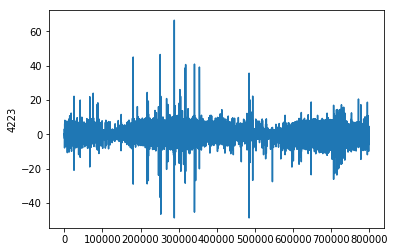

4223    1
Name: target, dtype: int64


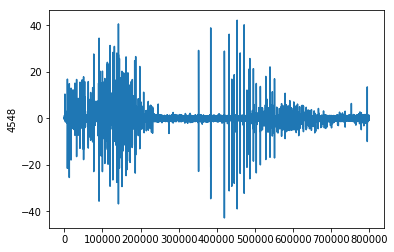

4548    1
Name: target, dtype: int64


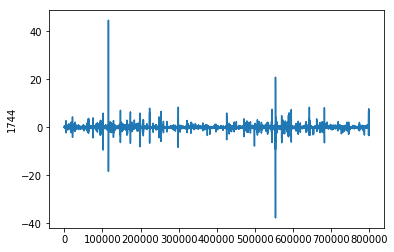

1744    0
Name: target, dtype: int64


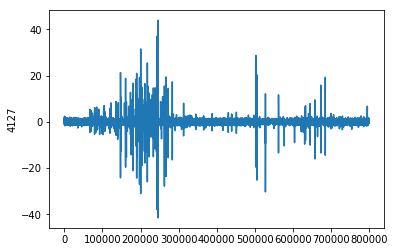

4127    1
Name: target, dtype: int64


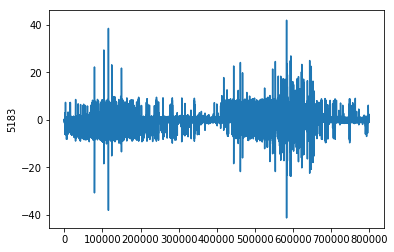

5183    1
Name: target, dtype: int64


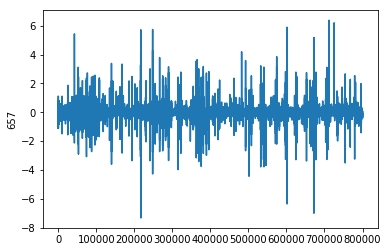

657    0
Name: target, dtype: int64


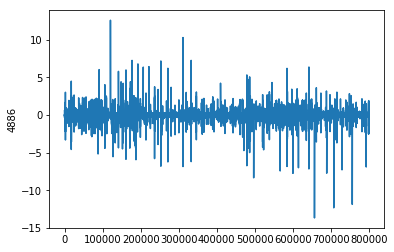

4886    0
Name: target, dtype: int64


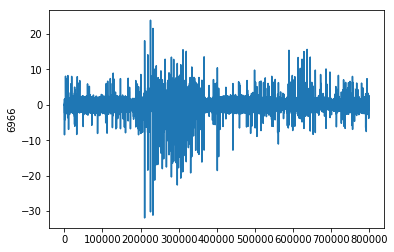

6966    1
Name: target, dtype: int64


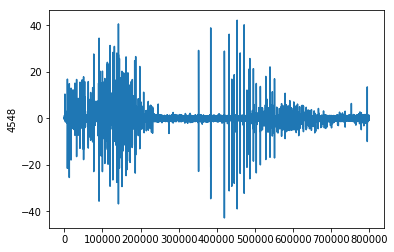

4548    1
Name: target, dtype: int64


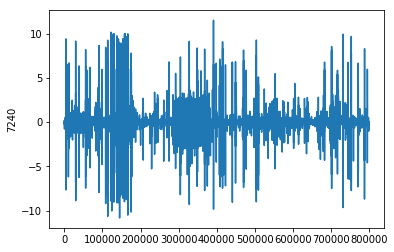

7240    0
Name: target, dtype: int64


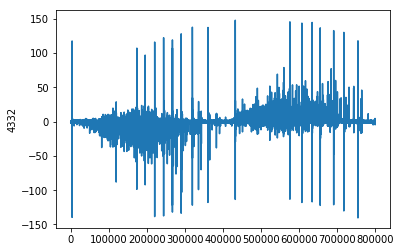

4332    1
Name: target, dtype: int64


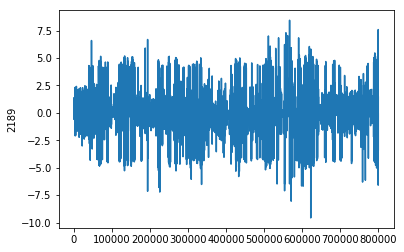

2189    0
Name: target, dtype: int64


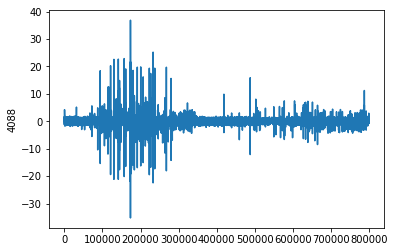

4088    1
Name: target, dtype: int64


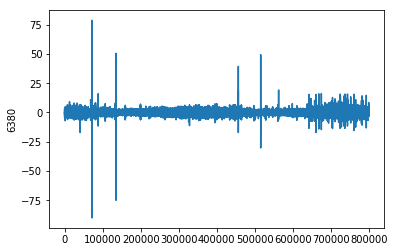

6380    1
Name: target, dtype: int64


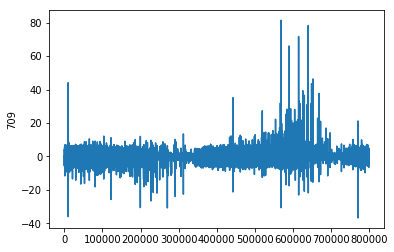

709    1
Name: target, dtype: int64


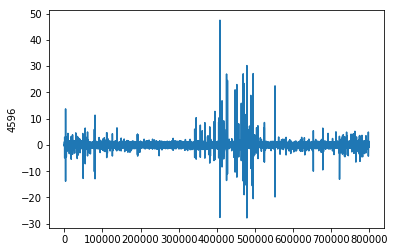

4596    1
Name: target, dtype: int64


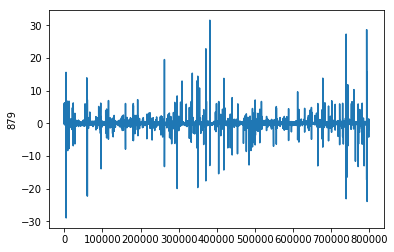

879    0
Name: target, dtype: int64


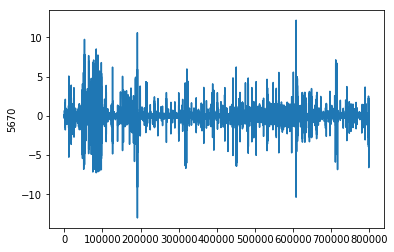

5670    0
Name: target, dtype: int64


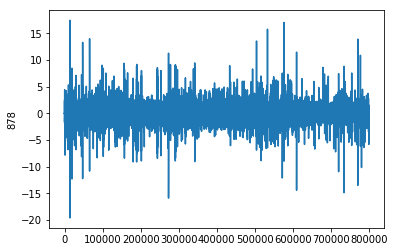

878    1
Name: target, dtype: int64


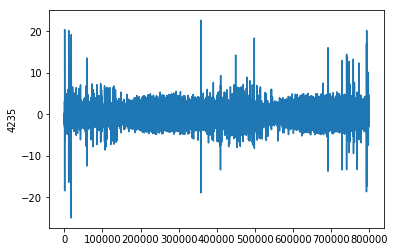

4235    1
Name: target, dtype: int64


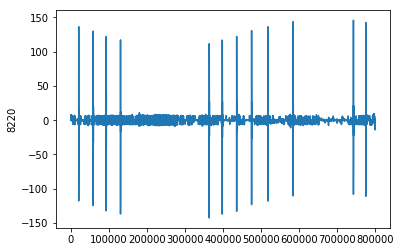

8220    0
Name: target, dtype: int64


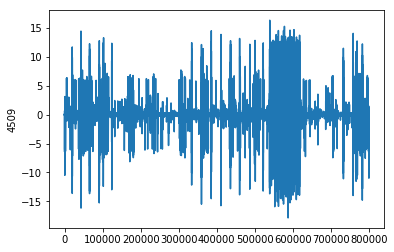

4509    0
Name: target, dtype: int64


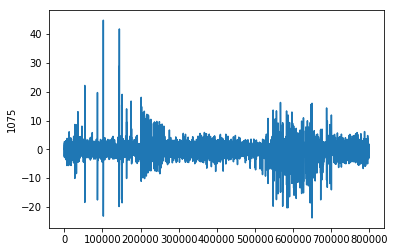

1075    1
Name: target, dtype: int64


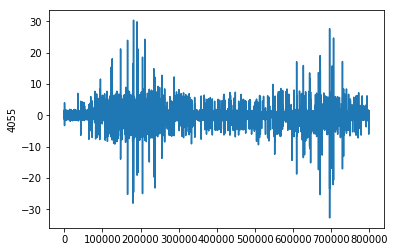

4055    1
Name: target, dtype: int64


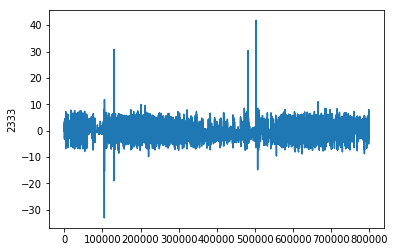

2333    0
Name: target, dtype: int64


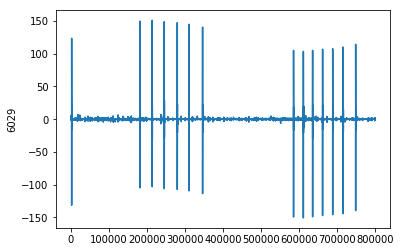

6029    0
Name: target, dtype: int64


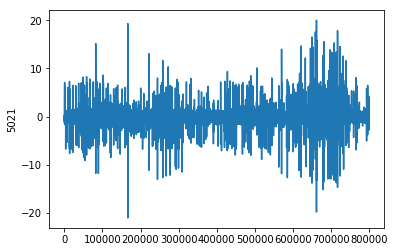

5021    1
Name: target, dtype: int64


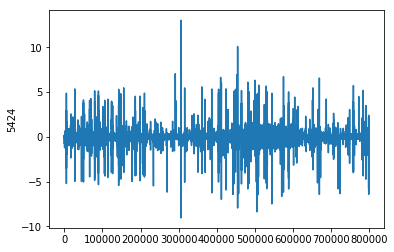

5424    0
Name: target, dtype: int64


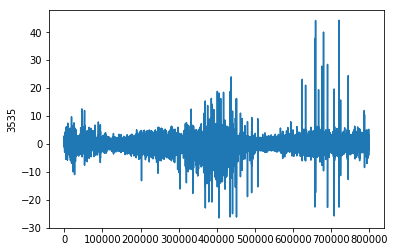

3535    1
Name: target, dtype: int64


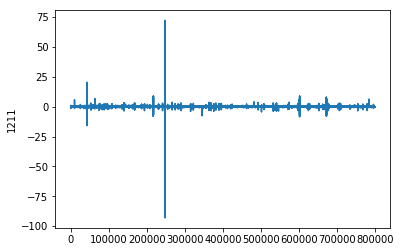

1211    0
Name: target, dtype: int64


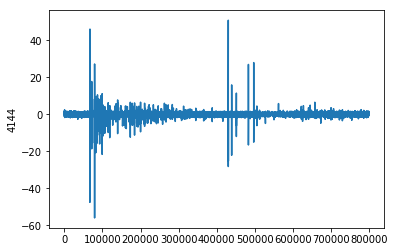

4144    1
Name: target, dtype: int64


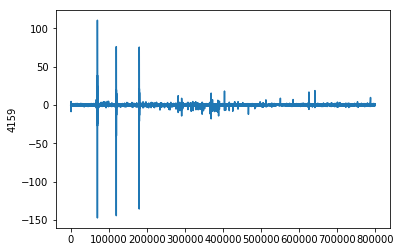

4159    1
Name: target, dtype: int64


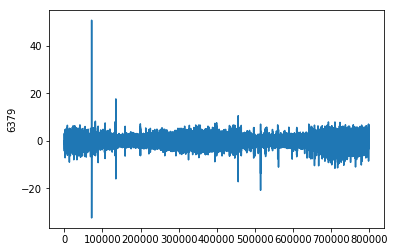

6379    1
Name: target, dtype: int64


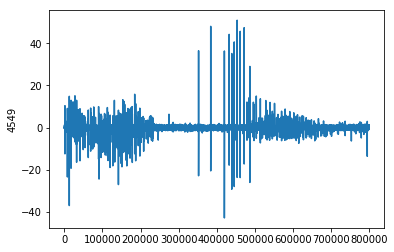

4549    1
Name: target, dtype: int64


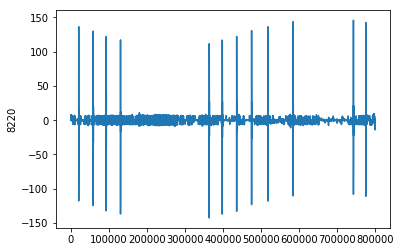

8220    0
Name: target, dtype: int64


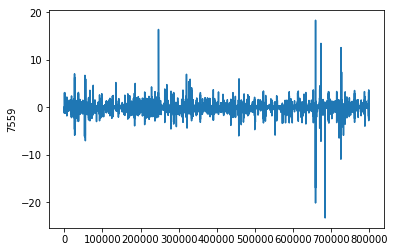

7559    0
Name: target, dtype: int64


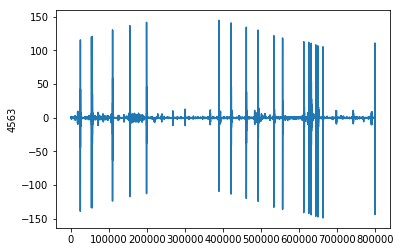

4563    0
Name: target, dtype: int64


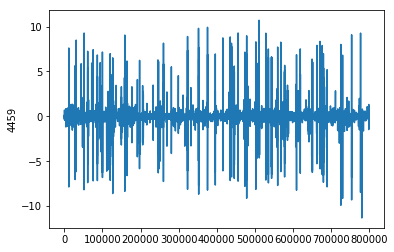

4459    0
Name: target, dtype: int64


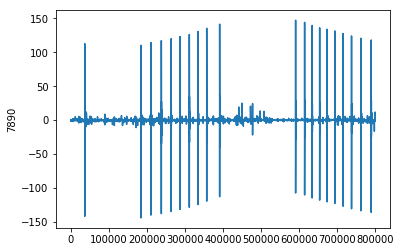

7890    0
Name: target, dtype: int64


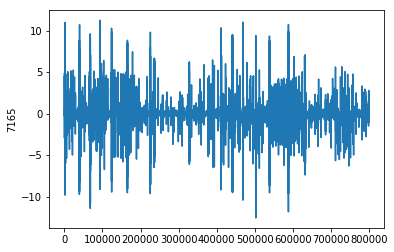

7165    0
Name: target, dtype: int64


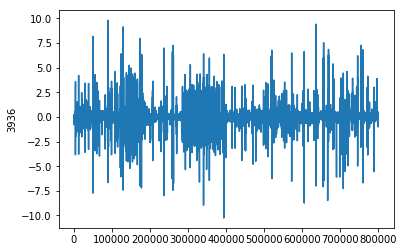

3936    0
Name: target, dtype: int64


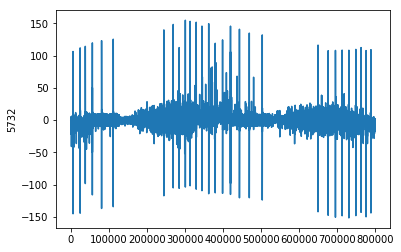

5732    1
Name: target, dtype: int64


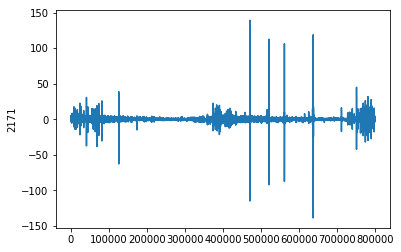

2171    1
Name: target, dtype: int64


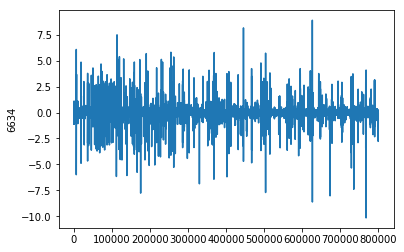

6634    0
Name: target, dtype: int64


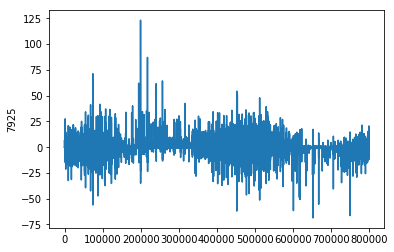

7925    1
Name: target, dtype: int64


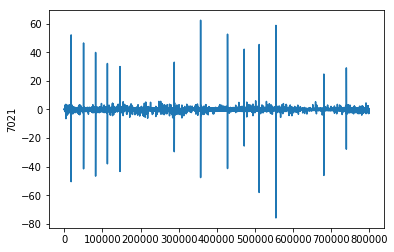

7021    1
Name: target, dtype: int64


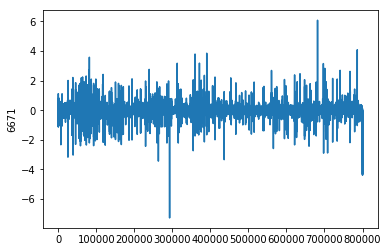

6671    0
Name: target, dtype: int64


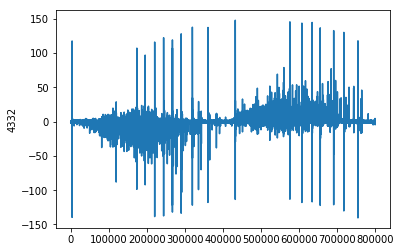

4332    1
Name: target, dtype: int64


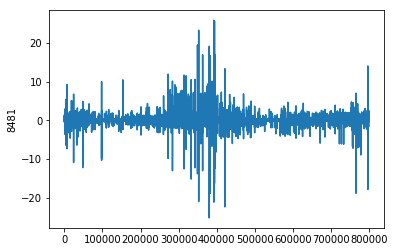

8481    1
Name: target, dtype: int64


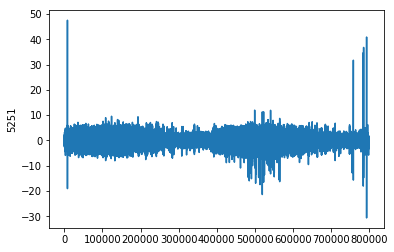

5251    1
Name: target, dtype: int64


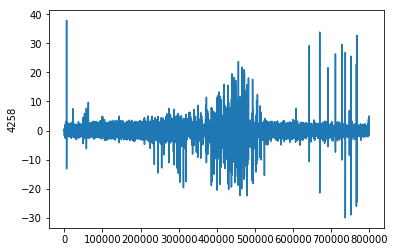

4258    1
Name: target, dtype: int64


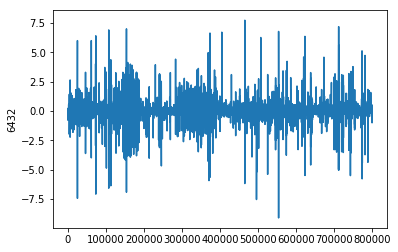

6432    0
Name: target, dtype: int64


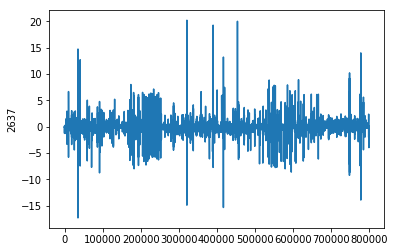

2637    0
Name: target, dtype: int64


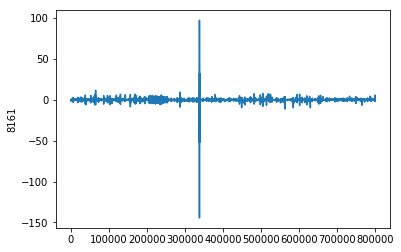

8161    0
Name: target, dtype: int64


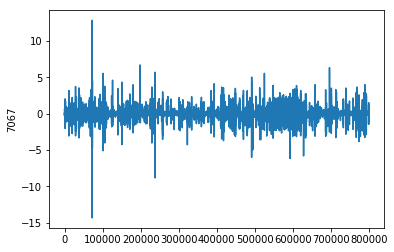

7067    0
Name: target, dtype: int64


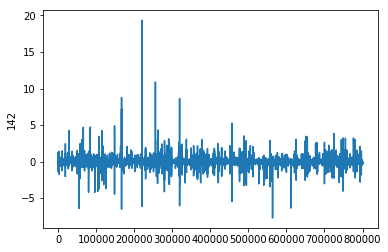

142    0
Name: target, dtype: int64


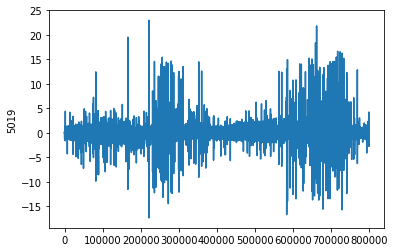

5019    1
Name: target, dtype: int64


In [14]:
signals_to_plot = random.choices(train_denoised_df.columns.tolist(), k=100)
for i in signals_to_plot:
    plt.figure()
    sns.lineplot(train_denoised_df.index, train_denoised_df[str(i)])
    plt.show()
    print(train_meta[train_meta['signal_id'] == int(i)]['target'])

In [15]:
train_denoised_df.to_parquet('../output/train_sig_2500hz_4th_order_dwt.parquet')